# About

These is a base solution of PID.

In [2]:
%matplotlib inline
import random
import pandas
import numpy
import cPickle as pickle
import matplotlib.pyplot as plt

import root_numpy
from sklearn.metrics import roc_auc_score, roc_curve

from rep.estimators import XGBoostClassifier, SklearnClassifier

from sklearn.ensemble import ExtraTreesClassifier
from rep.estimators import XGBoostClassifier, SklearnClassifier
from rep.metaml import FoldingClassifier

# Directories

In [3]:
track = 'Long'
particle = 'Electron'

data_path = "../../../data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/Long"

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
"multiclass/Long/XGBoost"

netconfig_path = "../../../data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_Long_ANN.txt"

# Read data

In [4]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

particles = ["Ghost", "Electron", "Muon", "Pion", "Kaon", "Proton"]
labs = [0, 1, 2, 3, 4, 5]

In [76]:
data = pandas.read_csv(data_path + "/data_train.csv")

In [77]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

# Balance data

In [78]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  170119
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  774220
Size of class 4 is  138261
Size of class 5 is  81951


In [79]:
selected_indexes = []

numpy.random.seed = 42

for i in numpy.unique(labels):
    
    indxs = numpy.random.choice(data.index[labels == i], 
                                size=min(50000, len(labels[labels == i])), 
                                replace=False)
    
    selected_indexes += list(indxs)

In [80]:
data.loc[selected_indexes].to_csv(data_path + "/data_train_balanced.csv")

# Read balanced data

In [81]:
data = pandas.read_csv(data_path + "/data_train_balanced.csv", index_col=0)

In [82]:
mc_p_type = numpy.abs(data.MCParticleType.values)
labels = numpy.zeros(len(mc_p_type))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels += one_lab * (mc_p_type == pdg)
    
numpy.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [83]:
for i in numpy.unique(labels):
    print "Size of class %d is " % i, (labels == i).sum()

Size of class 0 is  50000
Size of class 1 is  5610
Size of class 2 is  29839
Size of class 3 is  50000
Size of class 4 is  50000
Size of class 5 is  50000


# Features

In [5]:
# All allowable features
features = ['VeloCharge', 'BremPIDe', 'CaloNeutralPrs', 'CaloNeutralSpd', 'InAccBrem', 'InAccSpd', 'CaloPrsE',
            'InAccPrs', 'HcalPIDe', 'CaloHcalE', 'InAccHcal', 'CaloTrajectoryL', 'EcalPIDe', 'CaloNeutralEcal',
            'CaloTrMatch', 'CaloElectronMatch', 'CaloChargedPrs', 'CaloChargedSpd', 'MuonNShared', 'CaloBremMatch',
            'MuonIsLooseMuon', 'MuonIsMuon', 'MuonBkgLL', 'InAccEcal', 'MuonMuLL', 'TrackMatchChi2', 
            'TrackGhostProbability','EcalPIDmu', 'TrackPt', 'TrackP', 'NumProtoParticles', 'RichAboveMuThres',
            'NumCaloHypos', 'InAccMuon', 'TrackChi2PerDof', 'TrackNumDof', 'NumUpstreamTracks', 'NumLongTracks',
            'NumDownstreamTracks', 'CaloEcalChi2', 'NumRich1Hits', 'NumMuonTracks', 'CombDLLmu', 'CaloSpdE',
            'PrsPIDe', 'HcalPIDmu', 'NumSPDHits', 'NumVeloTracks', 'NumTTracks', 'TrackFitMatchChi2', 'CombDLLpi',
            'RichDLLbt', 'RichDLLpi', 'TrackCloneDist', 'TrackFitVeloNDoF', 'NumPVs', 'CombDLLp', 'TrackFitTChi2',
            'TrackFitTNDoF', 'RichAboveElThres', 'RichUsedAero', 'TrackDOCA', 'RichDLLe', 'TrackLikelihood',
            'CombDLLe', 'CombDLLk', 'CaloClusChi2', 'TrackFitVeloChi2', 'RichDLLp', 'RichUsedR1Gas', 'CaloBremChi2',
            'RichUsedR2Gas', 'CaloEcalE', 'RichAbovePiThres', 'CaloChargedEcal', 'NumRich2Hits', 'RichAboveKaThres',
            'RichAbovePrThres', 'RichDLLmu', 'RichDLLk']

# Features generation and selection

In [101]:
weights = numpy.zeros(len(labels))

for one_lab in labs:
    
    weights += 0.01*(labels == one_lab) * len(labels) / ((labels == one_lab).sum())
    
numpy.unique(weights)

array([ 0.0470898 ,  0.07890646,  0.41969519])

In [102]:
for i in numpy.unique(labels):
    print "Weight of class %d is " % i, weights[labels == i][0]

Weight of class 0 is  0.0470898
Weight of class 1 is  0.419695187166
Weight of class 2 is  0.0789064646939
Weight of class 3 is  0.0470898
Weight of class 4 is  0.0470898
Weight of class 5 is  0.0470898


In [103]:
from sklearn.cross_validation import train_test_split

train_inds, test_inds, labels_train, labels_test, weights_train, weights_test = train_test_split(data.index, 
                                                                                                 labels, 
                                                                                                 weights, 
                                                                                                 test_size=0.25, 
                                                                                                 random_state=42)

In [29]:
def get_feature_importances(new_features):
    
    sk_features = [u'CombDLLe', u'TrackGhostProbability', u'MuonIsMuon', u'MuonBkgLL',
                   u'CombDLLk', u'RichDLLk', u'MuonIsLooseMuon', u'MuonMuLL', u'CombDLLp',
                   u'RichDLLe', u'RichDLLp', u'RichDLLbt', u'CombDLLmu',
                   u'TrackChi2PerDof', u'TrackLikelihood', u'EcalPIDe',
                   u'RichAboveKaThres', u'TrackFitMatchChi2', u'PrsPIDe', u'RichDLLmu']
    
    sk_features = features
    
    forest = ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=4, min_samples_leaf=1, max_depth=8, max_features=0.5)
    sk = SklearnClassifier(forest, features=sk_features + new_features)
    
    sk.fit(data.loc[train_inds], labels_train, sample_weight=weights_train)
    
    imp = sk.get_feature_importances()
    
    return imp.loc[new_features]

In [ ]:
%%time

outputs = []
counter = 0

for one_num, one_feature in enumerate(features):
    for two_num, two_feature in enumerate(features):
        
        if one_num >= two_num:
            continue
        
        data[one_feature + '_add_' + two_feature] = data[one_feature].values + data[two_feature].values
        data[one_feature + '_sub_' + two_feature] = data[one_feature].values - data[two_feature].values
        data[one_feature + '_mul_' + two_feature] = data[one_feature].values * data[two_feature].values
        data[one_feature + '_div_' + two_feature] = data[one_feature].values / \
                                                    (data[two_feature].values + 10**-6)
        
        data[one_feature + '_add2_' + two_feature] = data[one_feature].values**2 + data[two_feature].values**2
        data[one_feature + '_sub2_' + two_feature] = data[one_feature].values**2 - data[two_feature].values**2
        
        
        new_features = []
        new_features += [one_feature + '_add_' + two_feature]
        new_features += [one_feature + '_sub_' + two_feature]
        new_features += [one_feature + '_mul_' + two_feature]
        new_features += [one_feature + '_div_' + two_feature]
        new_features += [one_feature + '_add2_' + two_feature]
        new_features += [one_feature + '_sub2_' + two_feature]
        
        out = get_feature_importances(new_features)
        outputs.append(out)
        
        data.drop(new_features, axis=1, inplace=True)
        
        counter += 1
        if counter % 100 == 0:
            print counter

In [31]:
len(outputs)

3160

In [32]:
df_outputs = pandas.concat(outputs)

In [6]:
df_outputs = pandas.read_csv(work_path + '/feature_importances3.csv', index_col=0)

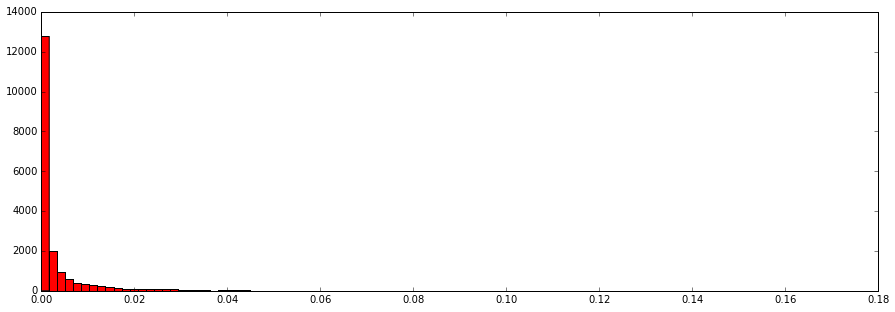

In [7]:
plt.figure(figsize=(15,5))
plt.hist(df_outputs.effect.values, bins=100)
plt.show()

In [8]:
df_outputs.sort(columns=['effect'], inplace=True, ascending=False)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [9]:
#df_outputs.to_csv(work_path + '/feature_importances1.csv')
#df_outputs.to_csv(work_path + '/feature_importances2.csv')
#df_outputs.to_csv(work_path + '/feature_importances3.csv')

In [10]:
p_cut = numpy.percentile(df_outputs.effect.values, 99)
p_cut

0.042757556367307978

In [11]:
df_sel_outputs = df_outputs[df_outputs.effect.values >= 0.08]

In [12]:
new_features = df_sel_outputs.index
len(new_features)

30

# Add new features

In [13]:
def add_new_features(data, features):

    for feature in new_features:
        [one_feature, operation, two_feature] = feature.split('_')
        
        if operation == 'add':
            
            data[feature] = data[one_feature].values + data[two_feature].values
            
        elif operation == 'sub':
            
            data[feature] = data[one_feature].values - data[two_feature].values
            
        elif operation == 'mul':
            
            data[feature] = data[one_feature].values * data[two_feature].values
            
        elif operation == 'div':
            
            data[feature] = data[one_feature].values / (data[two_feature].values + 10**-6)
            
        elif operation == 'add2':
            
            data[feature] = data[one_feature].values**2 + data[two_feature].values**2
            
        elif operation == 'sub2':
            
            data[feature] = data[one_feature].values**2 - data[two_feature].values**2
            
    return 1

In [104]:
add_new_features(data, new_features)

1

# Train XGBoost

In [107]:
%%time

clf = XGBoostClassifier(n_estimators=1000, 
                        colsample=0.7, 
                        eta=0.01, 
                        nthreads=4, 
                        subsample=0.5, 
                        max_depth=8,
                        min_child_weight = 50,
                        features=features + list(new_features))

clf.fit(data.loc[train_inds], labels_train, sample_weight=weights_train)

CPU times: user 5h 56min 58s, sys: 11.7 s, total: 5h 57min 10s
Wall time: 1h 31min 6s


# Feature importances

In [108]:
importances_dict = clf.xgboost_classifier.get_fscore()

In [109]:
importances_named = {}
for num, feature in enumerate(features+list(new_features)):
    
    if str(num) in importances_dict.keys():
        importances_named[feature] = importances_dict[str(num)]

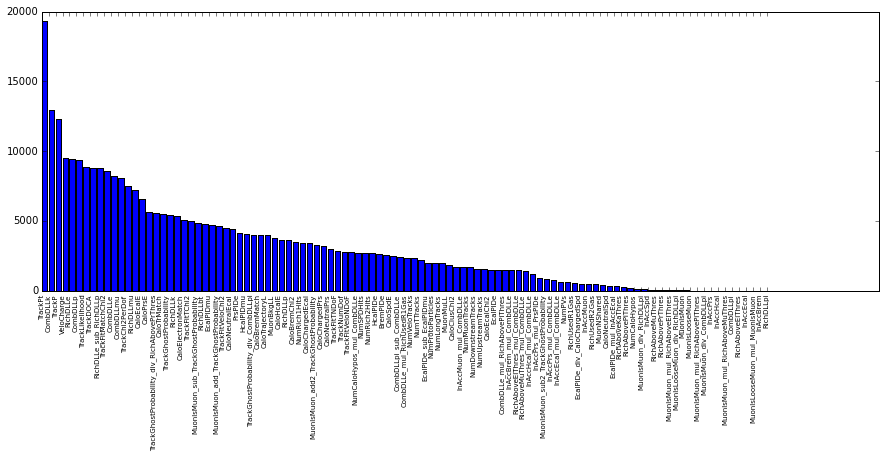

In [110]:
x = range(len(importances_named))
values = numpy.array(importances_named.values())
keys = numpy.array(importances_named.keys())


plt.figure(figsize=(15,5))
plt.bar(x, values[values.argsort()[::-1]])
plt.xticks(x, keys[values.argsort()[::-1]], rotation=90, size=7)
plt.show()

# Save the classifier

In [111]:
params = clf.get_params()
params_str = ""
for key, val in zip(params.keys(), params.values()):
    if key != "features":
        params_str += key + "=" + str(val) + ";"

In [112]:
new_work_path = work_path + "/" + params_str + 'balanced_data_' + str(len(data)) + 'new_features_part2'
new_work_path

'baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;gamma=None;nthreads=4;balanced_data_235449new_features_part2'

In [113]:
# Save classifier
import os
if not os.path.exists(new_work_path):
    os.makedirs(new_work_path)

clf_pickle = open(new_work_path + '/classifier.pkl', 'wb')
pickle.dump(clf, clf_pickle)
clf_pickle.close()

In [14]:
new_work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/\
multiclass/Long/XGBoost/verbose=0;missing=-999.0;scale_pos_weight=1.0;random_state=0;num_feature=None;\
base_score=0.5;n_estimators=1000;subsample=0.5;eta=0.01;min_child_weight=50;colsample=0.7;max_depth=8;\
gamma=None;nthreads=4;balanced_data_235449new_features_part2"

In [15]:
# Read classifier
clf_pickle2 = open(new_work_path + '/classifier.pkl', 'rb')
clf = pickle.load(clf_pickle2)
clf_pickle2.close()

# Test the classifier

In [114]:
%%time
probas = clf.predict_proba(data.loc[test_inds])

CPU times: user 3min 38s, sys: 452 ms, total: 3min 39s
Wall time: 57.2 s


In [115]:
probas[:5, :]

array([[  2.68663559e-03,   2.61039892e-03,   1.46837183e-03,
          1.52134767e-03,   4.23687458e-01,   5.68025768e-01],
       [  1.16630197e-02,   6.52982562e-04,   1.15012983e-03,
          6.18846156e-03,   8.19361627e-01,   1.60983801e-01],
       [  8.80104423e-01,   6.19284809e-02,   1.53937982e-02,
          1.91544630e-02,   1.39975250e-02,   9.42126475e-03],
       [  8.10641408e-01,   7.69603299e-04,   3.53906974e-02,
          7.31494576e-02,   3.19478400e-02,   4.81009819e-02],
       [  1.37165815e-01,   8.76866281e-03,   4.16794598e-01,
          3.58325899e-01,   3.82351279e-02,   4.07099575e-02]], dtype=float32)

### Logloss

In [116]:
from sklearn.metrics import log_loss

log_loss(labels_test, probas)

0.64887675249376719

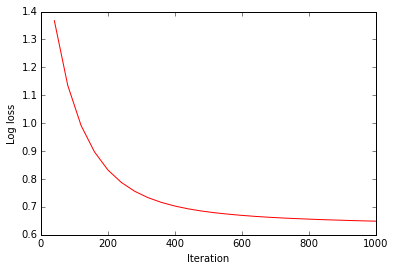

In [117]:

step = clf.get_params()['n_estimators'] / 25
staged_probas = clf.staged_predict_proba(data.loc[test_inds], step=step)

from sklearn.metrics import log_loss
log_loss_all = []
for pred in staged_probas:
    log_loss_all.append(log_loss(labels_test, pred))

x = numpy.arange(step, clf.get_params()['n_estimators'] + step, step)
plt.plot(x, log_loss_all)
plt.ylabel('Log loss')
plt.xlabel('Iteration')
plt.show()

In [118]:
log_loss_all

[1.3677244434265474,
 1.1357603455275171,
 0.99127375337020107,
 0.89692734936900453,
 0.83228239679415328,
 0.78776536102816952,
 0.75593976776230443,
 0.73301791862190513,
 0.71602445026528361,
 0.70302727767390771,
 0.69297045056314333,
 0.68512996262365611,
 0.67894192657593744,
 0.67388648997224976,
 0.66962312462946927,
 0.66599545864113407,
 0.66293802171958904,
 0.66037809437487649,
 0.65817285753092136,
 0.65616093921576801,
 0.65437310842127483,
 0.65284153743153939,
 0.65135974241217098,
 0.65004835210466427,
 0.64887675249376719]

### Roc curves

In [119]:
import os, sys
sys.path.append('../python')
import utils

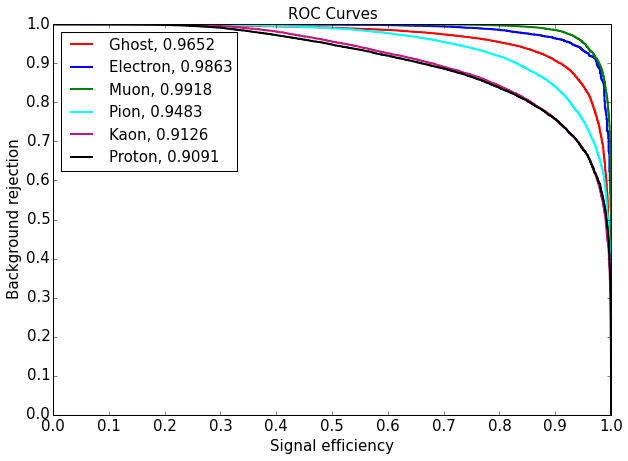

In [120]:
utils.get_roc_curves(labels_test, probas, particles, save_path=None, show=True)

# Evaluation

In [16]:
import os, sys
sys.path.append('../python')
import utils

In [17]:
data_eval = pandas.read_csv(data_path + "/data_eval.csv")

In [18]:
add_new_features(data_eval, new_features)

1

In [19]:
mc_p_type_eval = numpy.abs(data_eval.MCParticleType.values)
labels_eval = numpy.zeros(len(mc_p_type_eval))

for one_particle, one_lab in zip(particles, labs):
    
    pdg = particle_pdg_codes[one_particle]
    labels_eval += one_lab * (mc_p_type_eval == pdg)
    
numpy.unique(labels_eval)

array([ 0.,  1.,  2.,  3.,  4.,  5.])

In [20]:
%%time
proba_eval = clf.predict_proba(data_eval)

CPU times: user 46min 32s, sys: 5.6 s, total: 46min 38s
Wall time: 12min


In [21]:
#numpy.savetxt(new_work_path + '/xgboost_proba_eval.csv', proba_eval)

In [22]:
#proba_eval = numpy.loadtxt(new_work_path + '/xgboost_proba_eval.csv')

In [23]:
proba_eval[:5, :]

array([[  2.10570777e-03,   4.29708185e-03,   5.29245660e-03,
          3.55968252e-03,   1.21093616e-01,   8.63651454e-01],
       [  3.04858014e-03,   1.01388316e-03,   9.38860001e-04,
          1.81023672e-03,   4.17642266e-01,   5.75546205e-01],
       [  4.76942863e-03,   4.62941010e-04,   5.07451827e-03,
          9.59004283e-01,   1.77618358e-02,   1.29270460e-02],
       [  2.02288136e-01,   1.01085506e-01,   6.77860528e-03,
          4.76992249e-01,   1.00240044e-01,   1.12615481e-01],
       [  1.04848659e-02,   4.58114955e-04,   7.48675200e-04,
          9.85457659e-01,   1.28394179e-03,   1.56673661e-03]], dtype=float32)

### Get all figures from baseline

In [18]:
from get_figures import all_figures

In [19]:
for num in range(0, len(particles)):
        
    one_particle = particles[num]
    one_lab = labs[num]

    one_labels = (labels_eval == one_lab)*1
    one_probas = numpy.concatenate((1.-proba_eval[:, num].reshape(-1,1), proba_eval[:, num].reshape(-1,1)),axis=1)
    
    params = {}
    params['PARTICLE'] = one_particle
    params['TRACK'] = 'Long'
    
    all_figures(params, data_eval, one_probas, one_labels, features, path= new_work_path + "/"+ one_particle +"/pic")

### Logloss

In [24]:
from sklearn.metrics import log_loss

logloss = log_loss(labels_eval, proba_eval)
logloss

0.65101030364007262

### Roc curves, roc auc matrix and roc auc ratio matrix

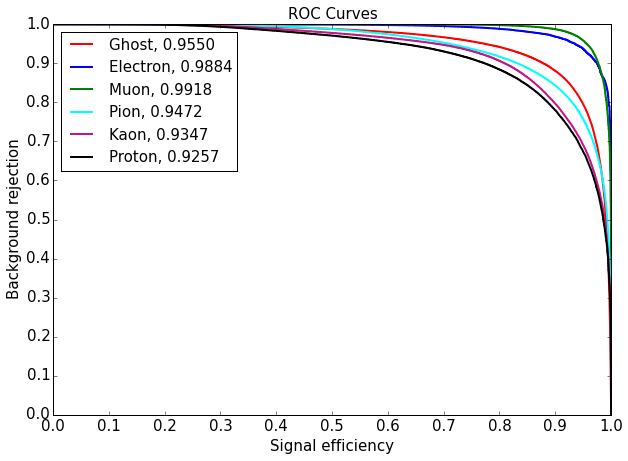

In [25]:
utils.get_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

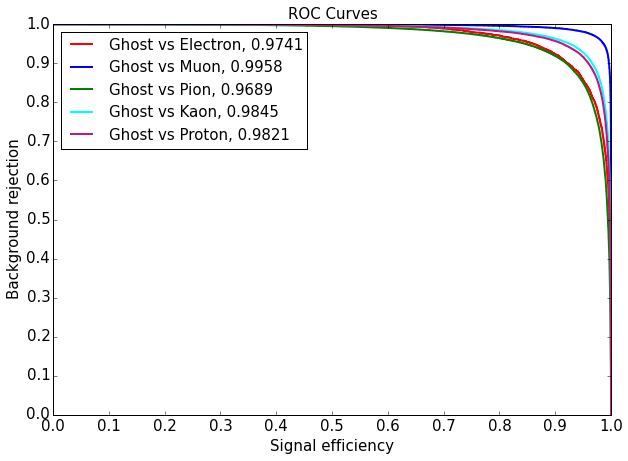

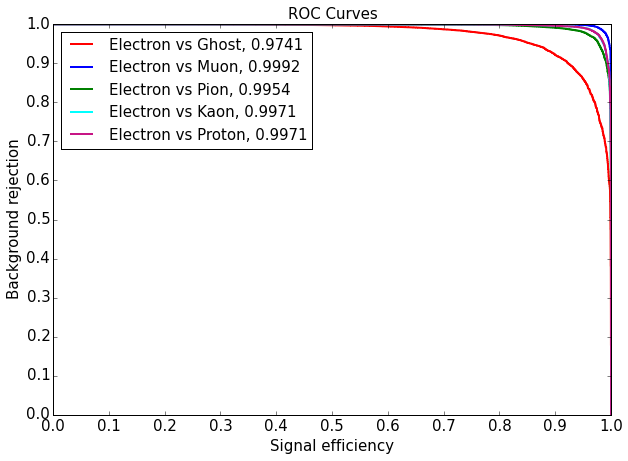

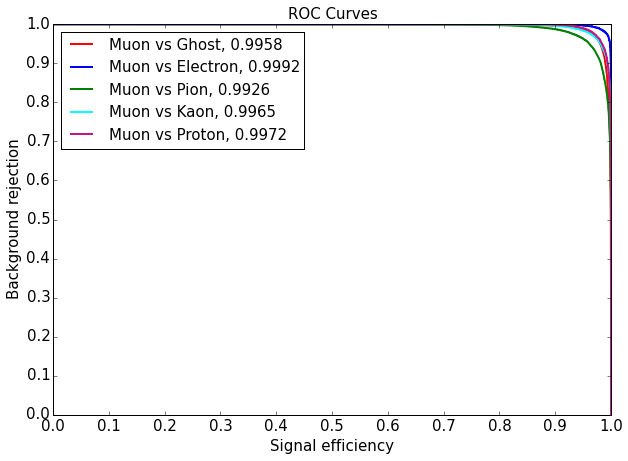

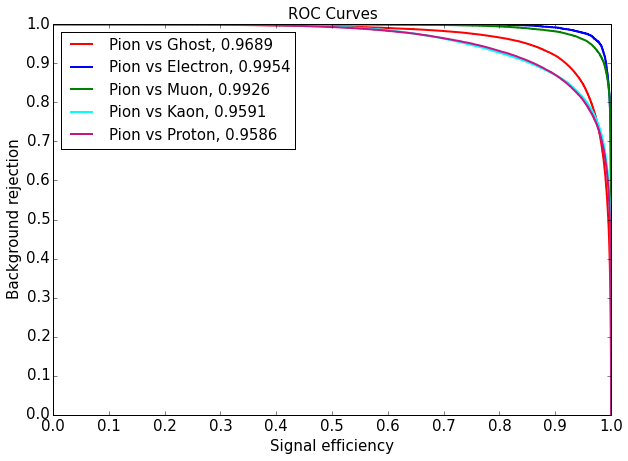

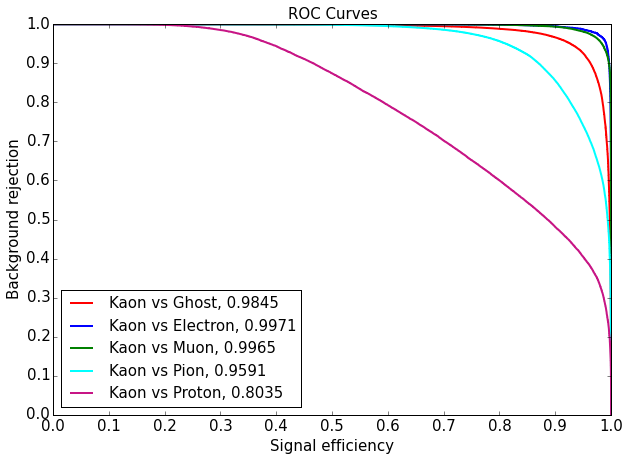

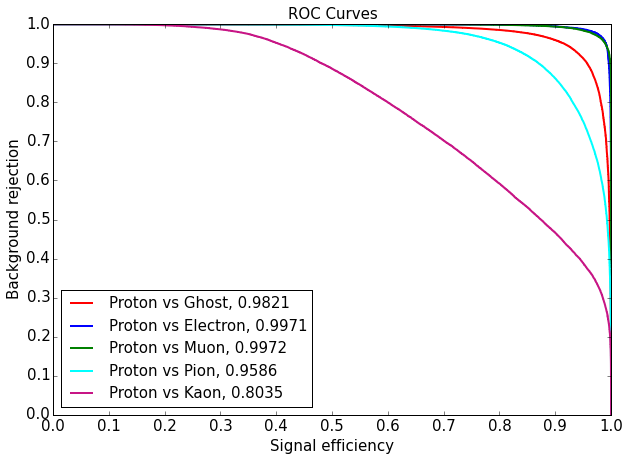

In [26]:
utils.get_one_vs_one_roc_curves(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


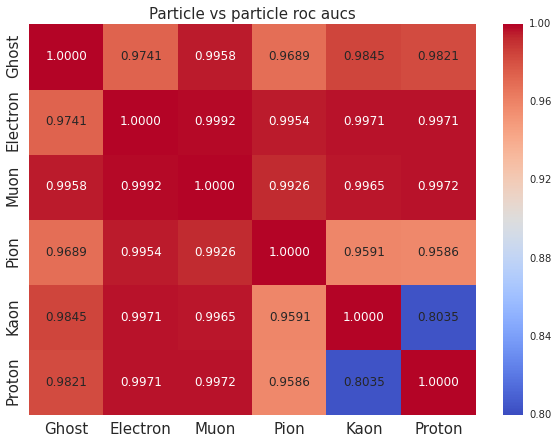

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,0.974066,0.995799,0.968909,0.984489,0.982064
Electron,0.974066,1.000000,0.999160,0.995386,0.997064,0.997075
Muon,0.995799,0.999160,1.000000,0.992639,0.996543,0.997184
Pion,0.968909,0.995386,0.992639,1.000000,0.959058,0.958554
Kaon,0.984489,0.997064,0.996543,0.959058,1.000000,0.803540
Proton,0.982064,0.997075,0.997184,0.958554,0.803540,1.000000


In [27]:
roc_auc_matrix = utils.get_roc_auc_matrix(labels_eval, proba_eval, particles, save_path=new_work_path, show=True)
roc_auc_matrix

In [28]:
roc_auc_matrix_baseline = pandas.read_csv("../python/class_vs_class_roc_auc_matrix_baseline.csv", index_col=0)

In [29]:
mean = 0
for one in range(0, 6):
    for two in range(0, 6):
        if one >= two:
            continue
        mean += roc_auc_matrix.iloc[one, two] / 15
        
mean

0.97343524101835721

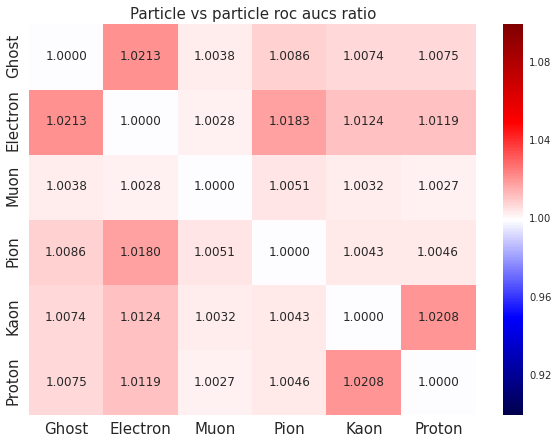

,Ghost,Electron,Muon,Pion,Kaon,Proton
Ghost,1.000000,1.021282,1.003801,1.008597,1.007421,1.007513
Electron,1.021283,1.000000,1.002782,1.018349,1.012366,1.011899
Muon,1.003801,1.002779,1.000000,1.005129,1.003187,1.002726
Pion,1.008597,1.018015,1.005104,1.000000,1.004316,1.004606
Kaon,1.007421,1.012399,1.003187,1.004317,1.000000,1.020795
Proton,1.007513,1.011894,1.002726,1.004605,1.020795,1.000000


In [30]:
utils.get_roc_auc_ratio_matrix(roc_auc_matrix, roc_auc_matrix_baseline, save_path=new_work_path, show=True)

### Flatness

In [31]:
%%time
flatness = utils.get_flatness_table(data_eval, labels_eval, proba_eval, particles, save_path=new_work_path)

CPU times: user 17min 30s, sys: 166 ms, total: 17min 31s
Wall time: 17min 31s


In [32]:
flatness

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Ghost,0.003643,0.012221,0.000876,0.000865
Electron,0.008995,0.030475,0.001004,0.000982
Muon,0.034057,0.046007,0.000900,0.000902
Pion,0.018151,0.015004,0.000853,0.000852
Kaon,0.047703,0.031367,0.000881,0.000865
Proton,0.036575,0.043430,0.000884,0.000897


In [33]:
flatness[['TrackP', 'TrackPt']].values.mean()

0.027302472006158689

In [34]:
flatness_baseline = pandas.read_csv("../python/flatness_baseline.csv", index_col=0)
flatness_baseline

,TrackP,TrackPt,P_Conf_level,Pt_Conf_level
Electron,0.006546,0.016579,0.001014,0.001004
Proton,0.034632,0.044571,0.000886,0.000888
Pion,0.016512,0.013729,0.000853,0.000851
Muon,0.020388,0.044991,0.000905,0.000906
Kaon,0.043074,0.036657,0.000872,0.000880
Ghost,0.006591,0.014187,0.000871,0.000870


In [35]:
utils.get_flatness_ratio(flatness, flatness_baseline, save_path=new_work_path)

,TrackP,TrackPt
Ghost,0.552757,0.861392
Electron,1.374165,1.838181
Muon,1.670466,1.022578
Pion,1.099243,1.092911
Kaon,1.107474,0.855693
Proton,1.056118,0.974396


### Efficiency curves

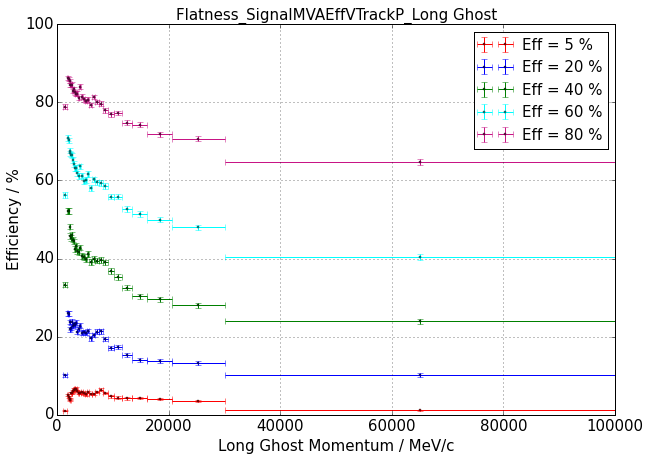

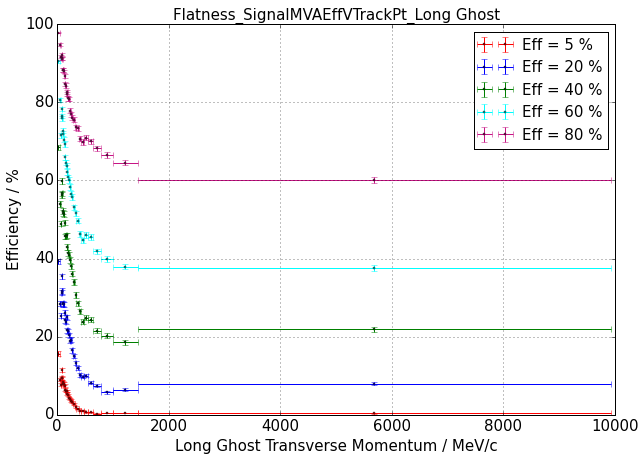

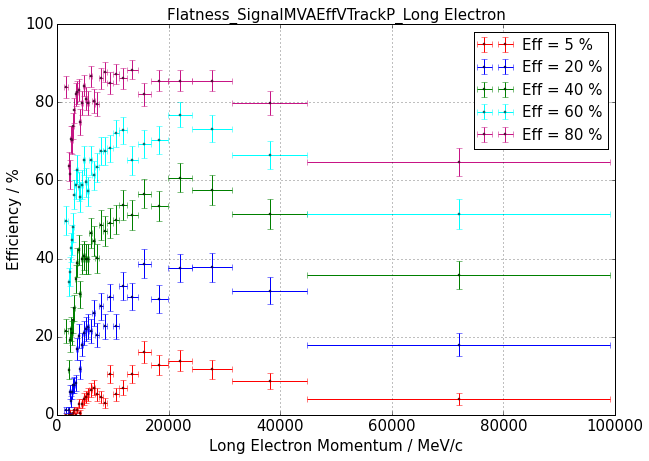

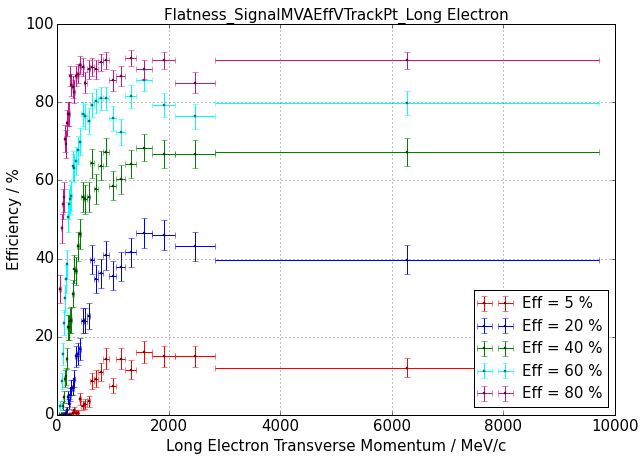

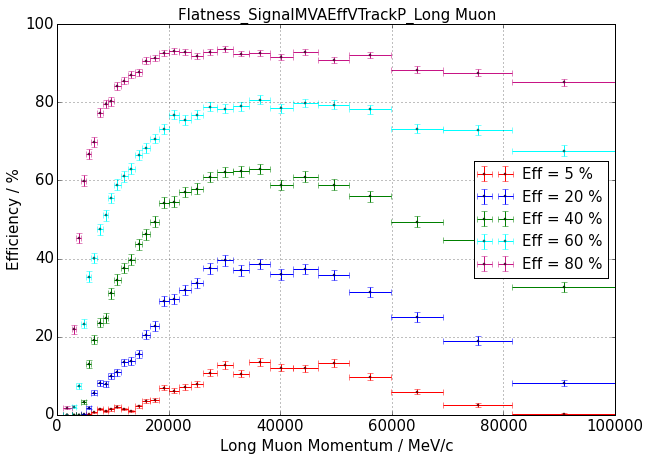

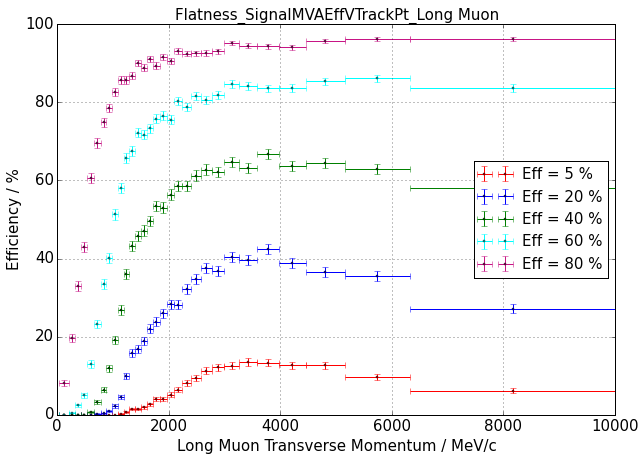

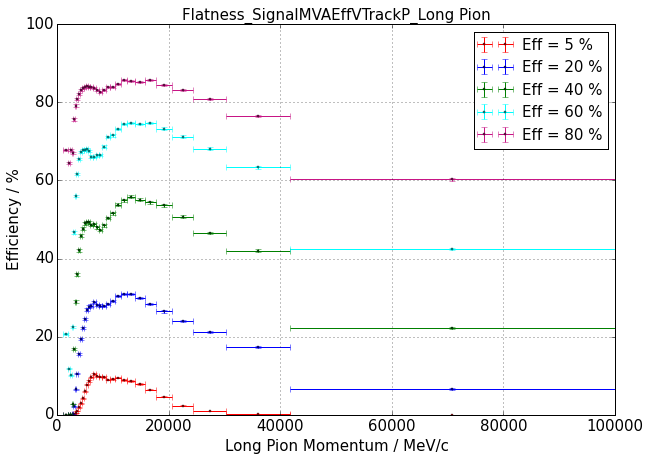

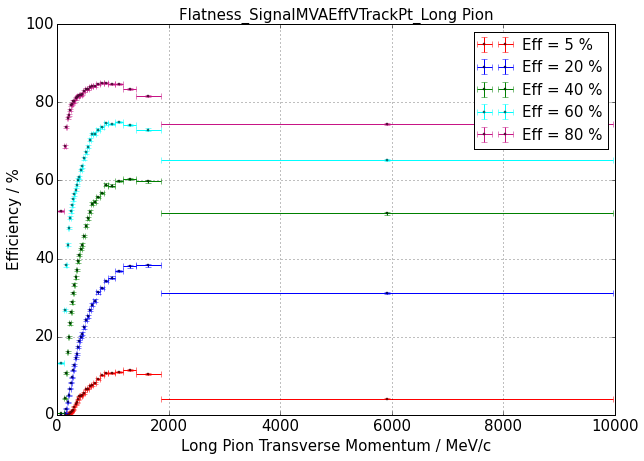

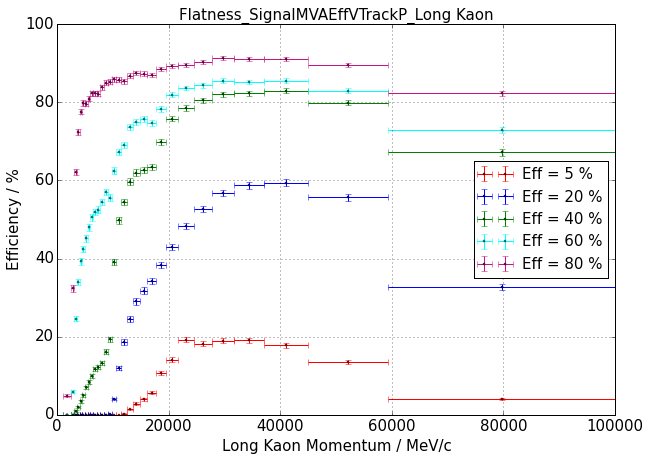

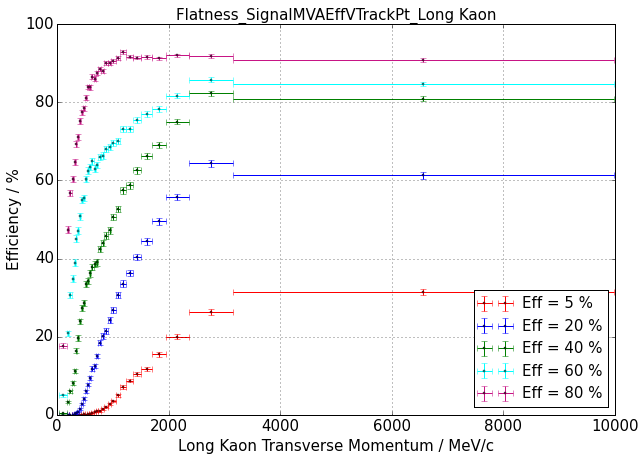

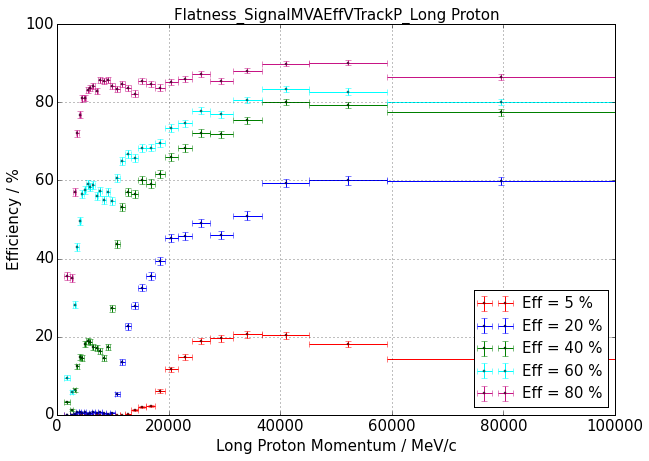

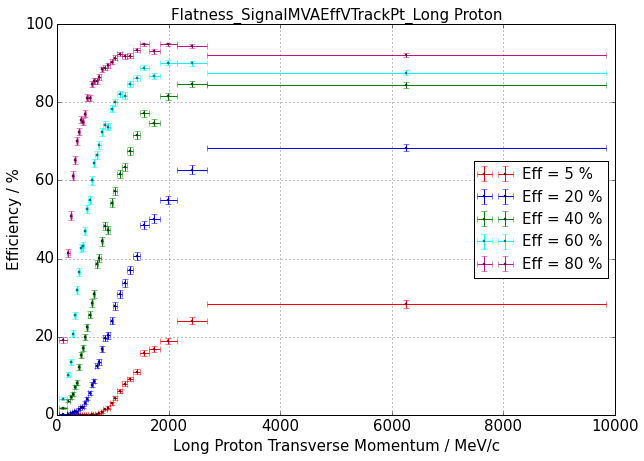

In [36]:
utils.get_all_flatness_figures(data_eval, proba_eval, labels_eval, 'Long', particles, save_path=new_work_path, show=True)